### **Nombre:** Elda Magally Calderón Motta
### **Carné:** 16003182
### **Sección:** Virtual

# Tensorflow: gradient descent y tensorboard

In [5]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 

In [6]:
import datetime

In [7]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


## Instalacion Tensorboard:

In [8]:
pip install --upgrade pip

Requirement already up-to-date: pip in c:\users\elda\anaconda3\lib\site-packages (20.1.1)
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [10]:
%tensorboard --Graphs logs/fit

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   {serve,dev} ...
tensorboard: error: invalid choice: 'logs/fit' (choose from 'serve', 'dev')

In [11]:
pip install jupyter-tensorboard

Note: you may need to restart the kernel to use updated packages.


## Hipotesis:

Dada la teoría matemática detrás del método de aprendizaje supervisado de Gradiente Descent, lo que se espera del experimento es:

* Que el error MSE o también llamado función de costo vaya descendiendo conforme vayan aumentando las iteraciones ejecutadas por el algoritmo

* Experimentar con diferentes valores de learning rate para encontrar uno adecuado que lleve a la convergencia 

* La recta de regresión vaya ajustándose mejor al dataset conforme vayan ejecutándose las iteraciones, lo cual va en relación a la disminución de la función de error

## Carga de Datos:

In [12]:
a=np.load('C:/Users/Elda/OneDrive/Data Science/2 Trimestre/Statistical Learning I/proyecto_training_data.npy')
print(a)

[[2.08500e+05 7.00000e+00 8.56000e+02 8.00000e+00 2.00300e+03 6.50000e+01]
 [1.81500e+05 6.00000e+00 1.26200e+03 6.00000e+00 1.97600e+03 8.00000e+01]
 [2.23500e+05 7.00000e+00 9.20000e+02 6.00000e+00 2.00100e+03 6.80000e+01]
 ...
 [2.66500e+05 7.00000e+00 1.18800e+03 9.00000e+00 1.94100e+03 6.60000e+01]
 [1.42125e+05 5.00000e+00 1.07800e+03 5.00000e+00 1.95000e+03 6.80000e+01]
 [1.47500e+05 5.00000e+00 1.25600e+03 6.00000e+00 1.96500e+03 7.50000e+01]]


De las cinco variables, aquella con mayor potencial predictivo es la que corresponde a:

* Calidad de los materiales // train[:,1] // - correlación = 0.7940

## Función de Costo:

<img src = "https://hackernoon.com/hn-images/0*DQ4rZdXEYzIf0iS_.png">

## Actualización de los parámetros:

<img src = "https://hackernoon.com/hn-images/0*8yzvd7QZLn5T1XWg.jpg">

## Definiendo la funcion para la hipotesis:

In [13]:
n = len(a[:,0])
x = np.reshape(a[:, 1], (n,1))
y = np.reshape(a[:, 0], (n,1))

In [14]:
def modelo_GD(x, y, lr, epochs):
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
   
        n = len(x)

        tensor_x = tf.placeholder(tf.float32,[n,1],"tensor_x")
        tensor_y = tf.placeholder(tf.float32,[n,1],"tensor_y")
        unos = tf.ones([n,1], tf.float32, "unos")
        matriz = tf.concat([tensor_x, unos], 1)

        parametros = tf.get_variable("pendiente", dtype=tf.float32, shape=[2, 1], initializer=tf.zeros_initializer())

        # hipotesis y = mx + b
        with tf.name_scope("Hipotesis"):
            y_hat = tf.matmul(matriz, parametros)
    
        # funcion de costo
        with tf.name_scope("Costo"):
            costo = tf.reduce_sum(tf.pow(y_hat - tensor_y, 2)) / (2 * n)
            scalar_costo = tf.summary.scalar('Scalar Modelo GD', costo)

    
        # gradiente
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(costo, [parametros])
            gradiente2 = gradiente[0]
    

        # actualizacion de parametros
        with tf.name_scope("Parametros"):
            parametros_actual = tf.add(tf.multiply(gradiente2, -lr), parametros)
            parametros = parametros.assign(parametros_actual)

        
        # batch gradient descent - uso de todo el dataset
        with tf.train.MonitoredSession() as session:
            
            writer = tf.summary.FileWriter(('./Model_GD_'+'LR='+str(lr)+'_Epochs='+str(epochs)), session.graph)

            feed_dict = {tensor_x: x, tensor_y: y}
    
            for i in range(epochs+1):

                session.run(gradiente2, feed_dict = feed_dict)
                session.run(parametros_actual, feed_dict = feed_dict)
                session.run(parametros, feed_dict = feed_dict)
                sc = session.run(scalar_costo,feed_dict=feed_dict)
                writer.add_summary(sc, epochs+1)
                session.run(costo,feed_dict=feed_dict)

                predicciones = session.run(y_hat,feed_dict=feed_dict)
        
    return(parametros_actual)


In [15]:
modelo_GD(x, y, 0.01, 2000)

INFO:tensorflow:Summary name Scalar Modelo GD is illegal; using Scalar_Modelo_GD instead.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<tf.Tensor 'Parametros/Add:0' shape=(2, 1) dtype=float32>

## Grafo:

In [16]:
from PIL import Image

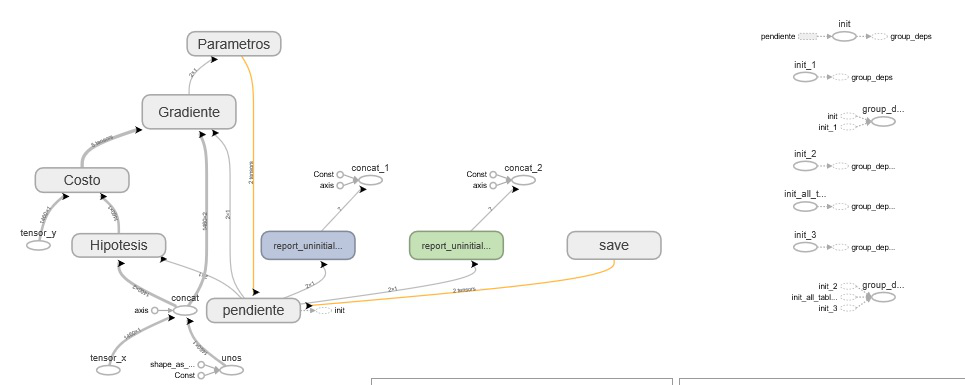

In [17]:
Image.open('Grafo 2 Tarea 1 GD.jpg','r') 

## Scalar:

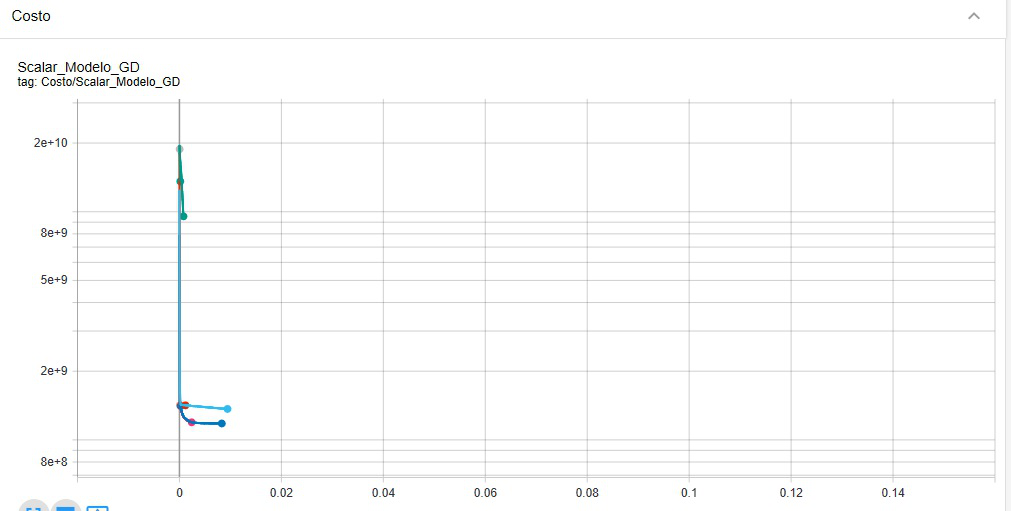

In [18]:
Image.open('Scalar 1 Tarea 1 GD.jpg','r') 

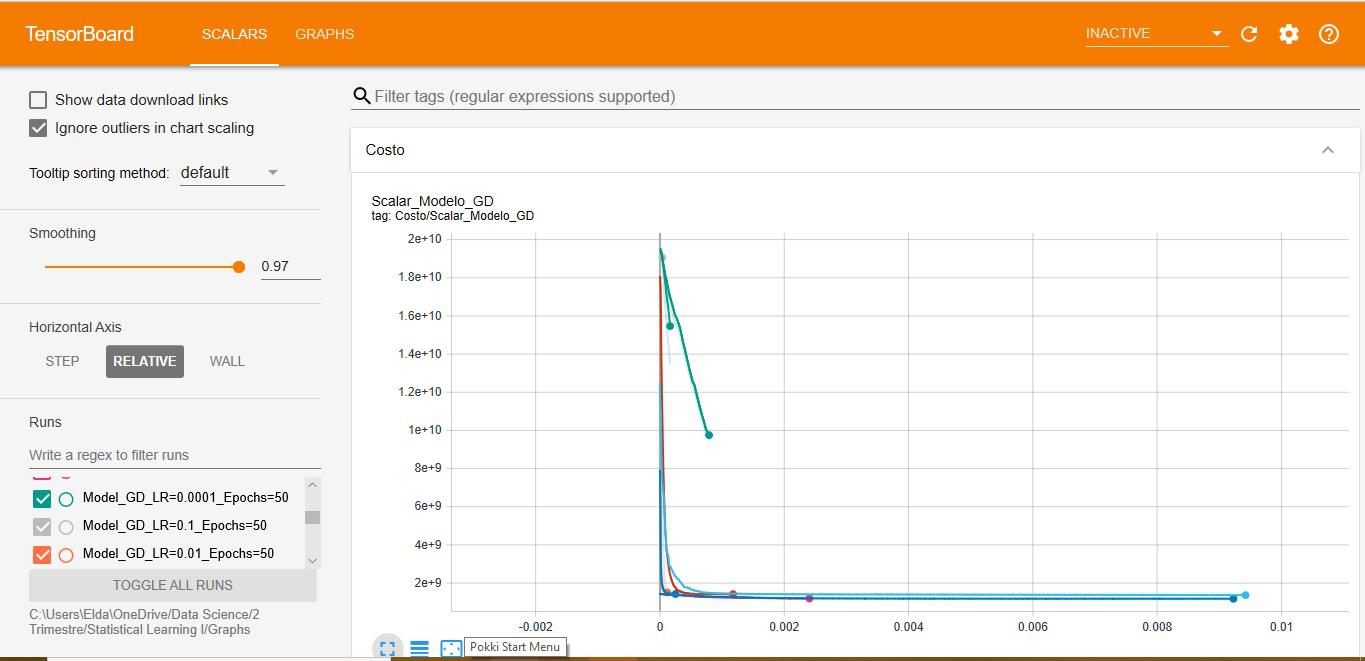

In [19]:
Image.open('Scalar 2 Tarea 1 GD.jpg','r') 

## Directorio:

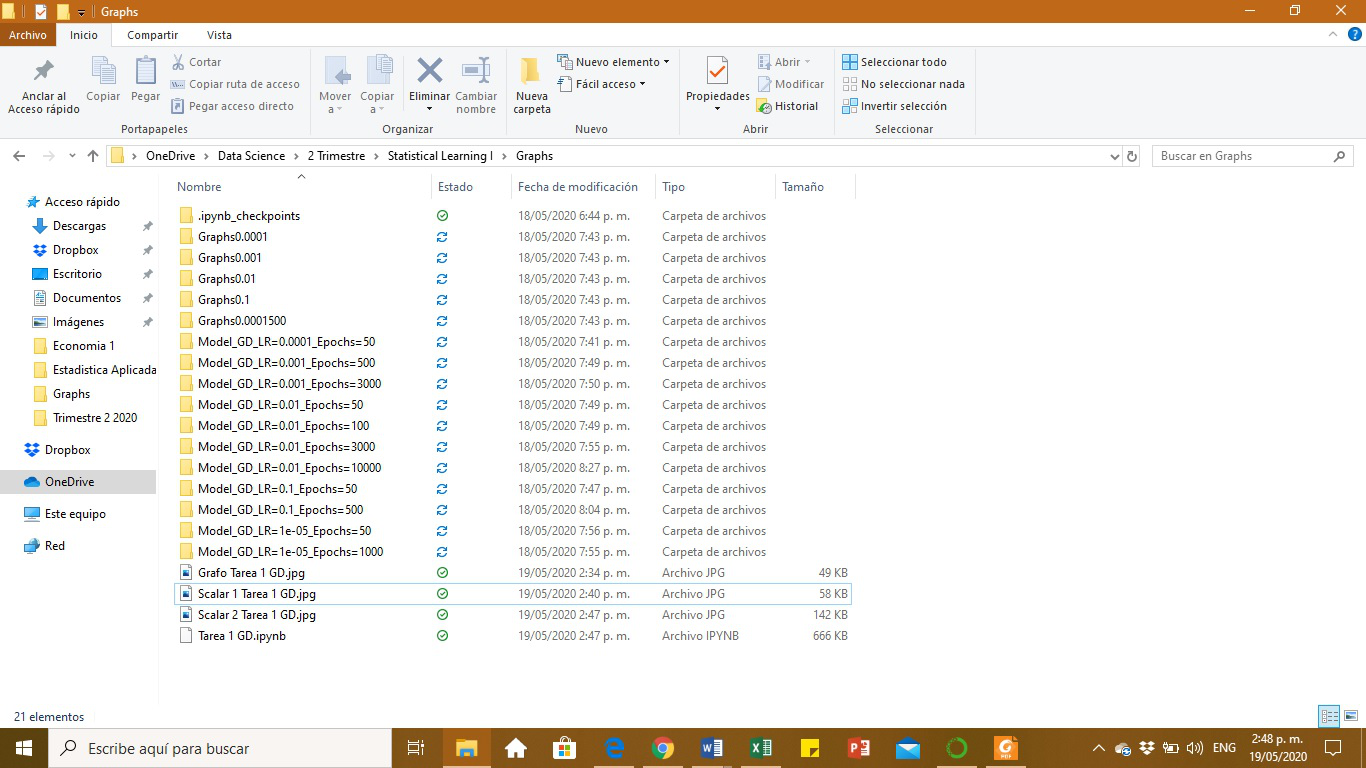

In [20]:
Image.open('Directorio.jpg','r') 

## Conclusion:

Se ejecutaron varios experimentos variando el valor de learning rate y la cantidad de iteraciones (epochs), obteniendo los siguientes resultados:

* Si el learning rate es muy pequeño la disminución de la función costo se hace más lenta y por tanto también la convergencia

* Si el learning rate es relativamente grande la gráfica de costo tiene un comportamiento de crecimiento en lugar de decrecer, lo que puede llevar a la divergencia. Se uso un valor de 0.1 con el cual se obtuvo este comportamiento

* De los valores de learning rate utilizados hay dos que proporcionaron buenos resultados en cuanto a la convergencia y disminución de la función costo: 0.01 y 0.001. De estos, el que disminuye más el costo es el valor de 0.01 y a su vez se observa una convergencia más rapida.

* Por tanto, se puede concluir que de los modelos generados el mejor es aquel con learning rate de 0.01 y con una cantidad de epochs de  3000 que permite visualizar que la función ha convergido.

In [21]:
def modelo_GD2(x, y, lr, epochs):
    
    tf.reset_default_graph()
    g = tf.Graph()

    with g.as_default():
   
        n = len(x)

        tensor_x = tf.placeholder(tf.float32,[n,1],"tensor_x")
        tensor_y = tf.placeholder(tf.float32,[n,1],"tensor_y")
        unos = tf.ones([n,1], tf.float32, "unos")
        matriz = tf.concat([tensor_x, unos], 1)

        parametros = tf.get_variable("pendiente", dtype=tf.float32, shape=[2, 1], initializer=tf.zeros_initializer())

        # hipotesis y = mx + b
        with tf.name_scope("Hipotesis"):
            y_hat = tf.matmul(matriz, parametros)
    
        # funcion de costo
        with tf.name_scope("Costo"):
            costo = tf.reduce_sum(tf.pow(y_hat - tensor_y, 2)) / (2 * n)
            #scalar_costo = tf.summary.scalar('Scalar Modelo GD', costo)

    
        # gradiente
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(costo, [parametros])
            gradiente2 = gradiente[0]
    

        # actualizacion de parametros
        with tf.name_scope("Parametros"):
            parametros_actual = tf.add(tf.multiply(gradiente2, -lr), parametros)
            parametros = parametros.assign(parametros_actual)


        plt.scatter(x, y)

        
        # batch gradient descent - uso de todo el dataset
        with tf.train.MonitoredSession() as session:
            
            writer = tf.summary.FileWriter(('./Model_GD_'+'LR='+str(lr)+'_Epochs='+str(epochs)), session.graph)

            feed_dict = {tensor_x: x, tensor_y: y}
    
            for i in range(epochs+1):

                #sc = session.run(scalar_costo,feed_dict=feed_dict)
                #writer.add_summary(sc, epochs+1)
                session.run(costo,feed_dict=feed_dict)

                print("Costo:")
                print(session.run(costo, feed_dict = feed_dict))
                
                print("Gradiente:")
                print(session.run(gradiente2, feed_dict = feed_dict))
                
                print("Parametros m y b:")
                print(session.run(parametros, feed_dict = feed_dict))
                print(session.run(y_hat, feed_dict = feed_dict))
        
                predicciones = session.run(y_hat,feed_dict=feed_dict)

        
                plt.plot(x,predicciones,label=str(i))

        plt.legend()
        plt.show()
        
    return(parametros_actual)


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Costo:
19519640000.0
Gradiente:
[[-1190340.4 ]
 [ -180921.25]]
Parametros m y b:
[[11903.403 ]
 [ 1809.2124]]
[[85133.03 ]
 [73229.63 ]
 [85133.03 ]
 ...
 [85133.03 ]
 [61326.227]
 [61326.227]]
Costo:
7927184400.0
Gradiente:
[[-713727.1 ]
 [-106509.44]]
Parametros m y b:
[[19040.674 ]
 [ 2874.3066]]
[[136159.03]
 [117118.35]
 [136159.03]
 ...
 [136159.03]
 [ 98077.67]
 [ 98077.67]]
Costo:
3762831600.0
Gradiente:
[[-428070.44]
 [ -61911.83]]
Parametros m y b:
[[23321.379 ]
 [ 3493.4248]]
[[166743.08]
 [143421.7 ]
 [166743.08]
 ...
 [166743.08]
 [120100.31]
 [120100.31]]
Costo:
2266776600.0
Gradiente:
[[-256863.1 ]
 [ -35183.36]]
Parametros m y b:
[[25890.01  ]
 [ 3845.2583]]
[[185075.33]
 [159185.33]
 [185075.33]
 ...
 [185075.33]
 [133295.31]
 [133295.31]]
Costo:
1729216400.0
Gradiente:
[[-154250.22 ]
 [ -19164.605]]
Parametros m y b:
[[27432.512 ]
 [ 4036.9043]]
[[19

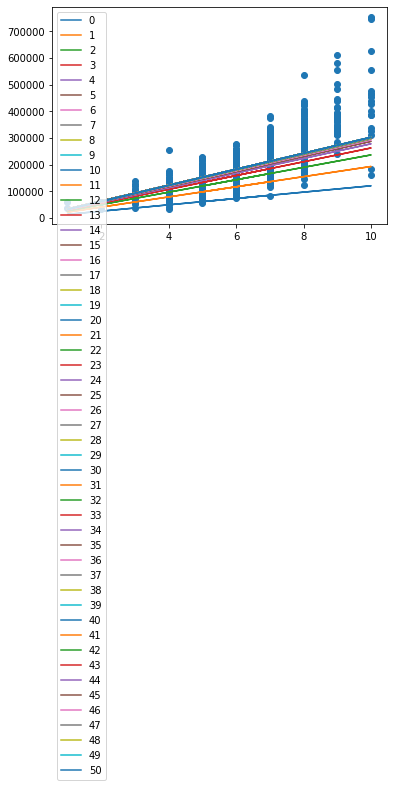

<tf.Tensor 'Parametros/Add:0' shape=(2, 1) dtype=float32>

In [22]:
modelo_GD2(x, y, 0.01, 50)